### Imports

In [2]:
import pandas as pd
from sklearn.preprocessing  import robust_scale
from sklearn.preprocessing  import OrdinalEncoder
from sklearn.preprocessing  import OneHotEncoder
from sklearn.decomposition  import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
from umap import UMAP
from hdbscan import HDBSCAN
import hdbscan
import numpy as np
from sklearn.naive_bayes import GaussianNB

sns.set_theme(context="paper", style="ticks")

Dateien einlesen

In [3]:
train = pd.read_csv("data\\train.csv")
test = pd.read_csv("data\\test.csv")

test_ID = test.PassengerId

In [4]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Proprocessing

In [5]:
def preprocess(df, fit, oh_enc, ordinal_enc):
    df["Deck"] = pd.DataFrame(df.Cabin.str.extract("([A-Z])", expand=False))
    categorical_cols = ["Sex", "Embarked"]
    drop_cols = ["Ticket", "Cabin", "Name", "PassengerId", "Sex", "Embarked", "Deck"]

    if fit:
        df = pd.concat([df, pd.DataFrame(oh_enc.fit_transform(df[categorical_cols].astype("str")))], axis=1)
        df = pd.concat([df, pd.DataFrame(ordinal_enc.fit_transform(np.array(df.Deck).reshape(-1,1)))], axis=1)

    else:
        df = pd.concat([df, pd.DataFrame(oh_enc.transform(df[categorical_cols].astype("str")))], axis=1)
        df = pd.concat([df, pd.DataFrame(ordinal_enc.transform(np.array(df.Deck).reshape(-1,1)))], axis=1)

    df.drop(labels=drop_cols, axis=1, inplace=True)
    df.fillna(-1, inplace=True)
    return (df)

In [6]:
oh_enc = OneHotEncoder(sparse=False)
ordinal_enc = OrdinalEncoder(categories=[["A", "B", "C", "D", "E", "F", "G", "T", np.nan]])

train = preprocess(train, fit=True, oh_enc=oh_enc, ordinal_enc=ordinal_enc)
test = preprocess(test, fit=False, oh_enc=oh_enc, ordinal_enc=ordinal_enc)

In [7]:
train_y = robust_scale(train.Survived)
train.drop("Survived", axis=1, inplace=True)
train_X = robust_scale(train)
test = robust_scale(test)

In [23]:
reducer = UMAP(
    n_components=4,
    n_neighbors=50,
    min_dist=0,
    # spread=1.1,
    # densmap=True,
    target_weight=0.3
)

clusterer = HDBSCAN(
    min_cluster_size=150,
    prediction_data=True
)

embedding_train = reducer.fit_transform(
    X=train_X,
    y=train_y
)

embedding_test = reducer.transform(
    X=test
)

clusterlabels = clusterer.fit_predict(embedding_train)

<AxesSubplot:>

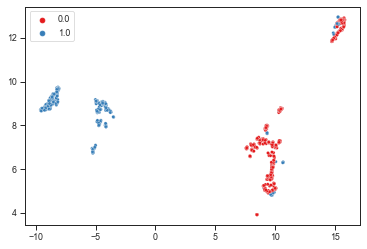

In [24]:
sns.scatterplot(
    x=embedding_train[:,0],
    y=embedding_train[:,1],
    hue=train_y,
    # style=clusterlabels,
    palette="Set1",
    s=10
)

<AxesSubplot:>

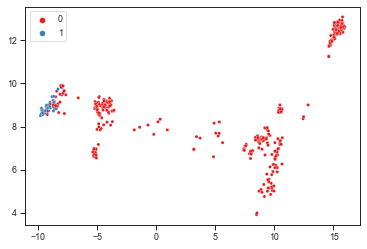

In [25]:
sns.scatterplot(
    x=embedding_test[:,0],
    y=embedding_test[:,1],
    hue=pred,
    # style=clusterlabels,
    palette="Set1",
    s=10
    )

In [26]:
lda = LinearDiscriminantAnalysis(
    # n_components=1
)

lda_train = lda.fit_transform(
    X=embedding_train,
    y=train_y
)
lda_test = lda.transform(embedding_test)

gnb = GaussianNB()
pred = gnb.fit(
    X=train_X,
    y=train_y).predict(test).astype("int")

In [27]:
lda.explained_variance_ratio_

array([1.])

In [28]:
submission = pd.DataFrame(columns=["PassengerId", "Survived"], data=zip(test_ID, pred))
submission.to_csv("submission.csv", index=False)

In [29]:
pca = PCA(
    n_components=4
)

pca_transform = pca.fit_transform(train)

C:\tools\miniconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
